In [17]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from itertools import product

In [2]:
np.random.seed(0)

In [3]:
# Number of samples for the first cluster
n_samples1 = 100

# Mean and standard deviation for the first cluster
mean1 = [2, 2]
cov1 = [[1, 0], [0, 1]]

# Generate the first cluster
cluster1 = np.random.multivariate_normal(mean1, cov1, n_samples1)


In [4]:
# Number of samples for the second cluster
n_samples2 = 100

# Mean and standard deviation for the second cluster
mean2 = [4, 4]
cov2 = [[1, 0], [0, 1]]

# Generate the second cluster
cluster2 = np.random.multivariate_normal(mean2, cov2, n_samples2)


In [5]:
# Combine the clusters
data = np.vstack((cluster1, cluster2))

# Create the labels (0 for the first cluster, 1 for the second cluster)
labels = np.concatenate((np.zeros(n_samples1), np.ones(n_samples2)))

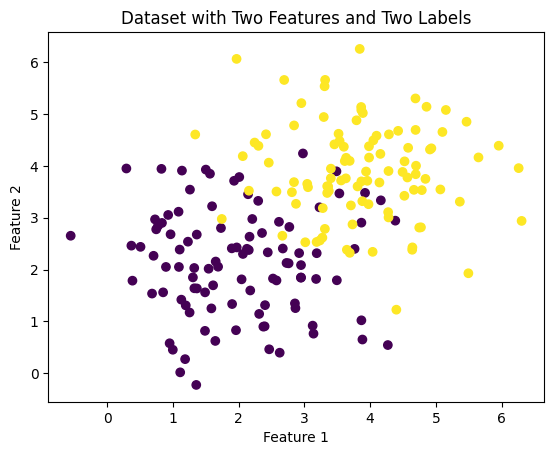

In [6]:
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Dataset with Two Features and Two Labels')
plt.show()


In [7]:
from sklearn.model_selection import train_test_split

# Assuming your dataset is stored in X (features) and y (labels)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)

In [8]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1,
                           random_state=42)

# Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Fit the model to the training data
gb_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gb_classifier.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8


In [9]:
# numpy implementation

In [10]:
import numpy as np

# Define the decision tree node class
class Node:
    def __init__(self, feature_index=None, threshold=None, value=None, left=None, right=None):
        self.feature_index = feature_index  # Index of the feature to split on
        self.threshold = threshold          # Threshold value for the split
        self.value = value                  # Value to predict at the node (leaf node)
        self.left = left                    # Left child (subtree)
        self.right = right                  # Right child (subtree)

# Define the decision tree regressor class
class DecisionTreeRegressor:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.root = None

    def mean_squared_error(self, y):
        return np.mean((y - np.mean(y)) ** 2)

    def best_split(self, X, y):
        best_mse = np.inf
        best_feature_index = None
        best_threshold = None

        n_features = X.shape[1]
        for feature_index in range(n_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                mask = X[:, feature_index] <= threshold
                left_targets = y[mask]
                right_targets = y[~mask]

                if len(left_targets) == 0 or len(right_targets) == 0:
                    continue

                mse = len(left_targets) * self.mean_squared_error(left_targets) + \
                      len(right_targets) * self.mean_squared_error(right_targets)

                if mse < best_mse:
                    best_mse = mse
                    best_feature_index = feature_index
                    best_threshold = threshold

        return best_feature_index, best_threshold

    def build_tree(self, X, y, depth):
        # Stopping criteria
        if depth == self.max_depth or len(np.unique(y)) == 1:
            return Node(value=np.mean(y))

        feature_index, threshold = self.best_split(X, y)
        if feature_index is None or threshold is None:
            return Node(value=np.mean(y))

        mask = X[:, feature_index] <= threshold
        left_X, left_y = X[mask], y[mask]
        right_X, right_y = X[~mask], y[~mask]

        left_node = self.build_tree(left_X, left_y, depth + 1)
        right_node = self.build_tree(right_X, right_y, depth + 1)

        return Node(feature_index=feature_index, threshold=threshold, left=left_node, right=right_node)

    def fit(self, X, y):
        self.root = self.build_tree(X, y, depth=0)

    def predict_single(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature_index] <= node.threshold:
            return self.predict_single(x, node.left)
        else:
            return self.predict_single(x, node.right)

    def predict(self, X):
        predictions = []
        for x in X:
            prediction = self.predict_single(x, self.root)
            predictions.append(prediction)
        return np.array(predictions)


In [11]:
# Define the gradient boosting regression tree class
class GradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # Initialize the target variable with the mean
        target = np.mean(y) * np.ones_like(y)

        for _ in range(self.n_estimators):
            # Calculate the negative gradient (pseudo-residuals)
            residuals = y - self.sigmoid(target)

            # Fit a regression tree to the residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)

            # Update the target variable
            target += self.learning_rate * tree.predict(X)

            # Add the tree to the ensemble
            self.models.append(tree)

    def predict(self, X):
        # Initialize the predictions with zeros
        predictions = np.zeros(len(X))

        # Make predictions using each tree in the ensemble
        for tree in self.models:
            predictions += self.learning_rate * tree.predict(X)

        # Apply sigmoid function to convert to probabilities
        probabilities = self.sigmoid(predictions)

        # Round probabilities to obtain binary predictions
        binary_predictions = np.round(probabilities)

        return binary_predictions

In [12]:
# Create a Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

# Fit the model to the training data
gb_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gb_regressor.predict(X_test)

# Calculate the accuracy of the model
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.85


In [18]:
n_estimators_vec = [50, 100, 200]
learning_rate_vec = [0.1, 0.05]
max_depth_vec = [2,3,4]

results = {}

for n_estimators, learning_rate, max_depth in (product(n_estimators_vec , learning_rate_vec, max_depth_vec)):
    gb_regressor = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
    gb_regressor.fit(X_train, y_train)
    y_pred = gb_regressor.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    
    results[(n_estimators, learning_rate, max_depth)] = (accuracy)


results_df = pd.DataFrame(columns = ["n_estimators", "learning_rate", "max_depth", "test_accuracy"])
for (n_estimators, learning_rate, max_depth), (accuracy) in results.items():
    results_df.loc[len(results_df)] = [n_estimators, learning_rate, max_depth, accuracy]
    
print("Results summary table")
results_df.sort_values(by=['accuracy'], ascending=False)

NameError: name 'pd' is not defined

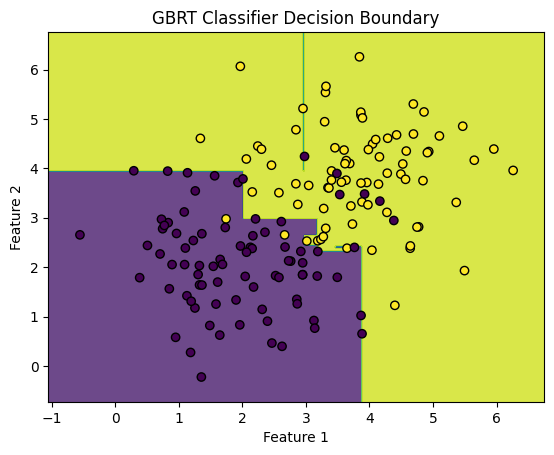

In [13]:
# Plot the decision boundary
def plot_decision_boundary(clf, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('GBRT Classifier Decision Boundary')
    plt.show()

# Plot the decision boundary and the training data
plot_decision_boundary(gb_regressor, X_train, y_train)